In [68]:
import pandas as pd
import re
import numpy as np
from datetime import date

In [69]:
file_2025 = "weekly-infectious-disease-bulletin-year-2025.xlsx"
file_2026 = "weekly-infectious-disease-bulletin-year-2026.xlsx"

In [73]:
# LOAD EXCEL (2-ROW HEADER) + FLATTEN COLUMNS

def load_bulletin(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, header=[0, 1])

    def flatten(col_tuple):
        parts = []
        for p in col_tuple:
            if p is None:
                continue
            s = str(p).replace("\n", " ").strip()
            if s.lower() == "nan" or s == "":
                continue
            parts.append(s)
        return " ".join(parts).strip()

    df.columns = [re.sub(r"\s+", " ", flatten(c)).strip() for c in df.columns]
    return df

df_2025 = load_bulletin(file_2025)
df_2026 = load_bulletin(file_2026)


In [74]:
#  STANDARDIZE WEEK COLUMNS (EPI WEEK + WEEK RANGE)
#    - Find week_range by matching dd/mm/yyyy - dd/mm/yyyy pattern in values

def standardize_week_cols(df: pd.DataFrame) -> pd.DataFrame:
    # Find Epidemiology week column by name
    epi_candidates = [c for c in df.columns if "epidemiology" in c.lower() and "wk" in c.lower()]
    if not epi_candidates:
        raise ValueError("Could not find Epidemiology Wk column. Print df.columns to inspect.")

    # Find week range column by value pattern
    pattern = re.compile(r"\d{1,2}/\d{1,2}/\d{4}\s*-\s*\d{1,2}/\d{1,2}/\d{4}")
    week_candidates = []
    for c in df.columns:
        s = df[c].astype(str)
        if s.str.contains(pattern, na=False).any():
            week_candidates.append(c)

    if not week_candidates:
        # fallback by column name (rarely needed)
        week_candidates = [c for c in df.columns if ("start" in c.lower() and "end" in c.lower())]

    if not week_candidates:
        raise ValueError("Could not find week range column. Inspect df.head() and df.columns.")

    df = df.rename(columns={epi_candidates[0]: "epi_week", week_candidates[0]: "week_range"})
    return df

df_2025 = standardize_week_cols(df_2025)
df_2026 = standardize_week_cols(df_2026)


In [75]:
# PARSE WEEK_START FROM WEEK_RANGE (SURVEILLANCE WEEK START)

def add_week_start(df: pd.DataFrame) -> pd.DataFrame:
    df["week_start"] = (
        df["week_range"].astype(str)
        .str.split("-").str[0]
        .str.strip()
    )
    df["week_start"] = pd.to_datetime(df["week_start"], dayfirst=True, errors="coerce")
    return df

df_2025 = add_week_start(df_2025)
df_2026 = add_week_start(df_2026)

In [76]:
# LABEL DATA
#    Using bulletin_year (file year) + ISO week-year for correct cross-country alignment.

df_2025["country"] = "Singapore"
df_2026["country"] = "Singapore"
df_2025["bulletin_year"] = 2025
df_2026["bulletin_year"] = 2026

df = pd.concat([df_2025, df_2026], ignore_index=True)


In [77]:
# ISO WEEK-YEAR + ISO WEEK

iso = df["week_start"].dt.isocalendar()
df["iso_year"] = iso["year"].astype("Int64")
df["iso_week"] = iso["week"].astype("Int64")

def iso_week_start(year, week):
    # ISO: Monday = 1
    return pd.to_datetime(f"{int(year)}-W{int(week):02d}-1", format="%G-W%V-%u")

df["week_start_iso"] = df.apply(
    lambda r: iso_week_start(r["iso_year"], r["iso_week"]) if pd.notna(r["iso_year"]) and pd.notna(r["iso_week"]) else pd.NaT,
    axis=1
)

In [78]:
# FILTER DATE RANGE (DON'T DROP EPI WEEK 1 THAT MAY START IN DEC)
#    Using buffer start date + today

start_date = pd.Timestamp("2024-12-01")  # buffer to include 2025 week 1 if it starts in late Dec 2024
end_date = pd.Timestamp(date.today())

df = df[df["week_start"].between(start_date, end_date)]

In [79]:
#  DROP CORRUPT ROWS (MISSING WEEK_START OR EPI_WEEK)
df = df.dropna(subset=["week_start", "epi_week", "iso_year", "iso_week"])

In [80]:
# RESHAPE WIDE -> LONG
#    Keep everything except IDs + week_range as values (disease/metric columns)

ID_COLS = ["country", "bulletin_year", "iso_year", "iso_week", "epi_week", "week_start"]

value_cols = [c for c in df.columns if c not in ID_COLS and c not in ["week_range", "week_start_iso"]]

df_long = df.melt(
    id_vars=ID_COLS,
    value_vars=value_cols,
    var_name="metric_disease",
    value_name="value"
)

# Clean numeric
df_long["value"] = pd.to_numeric(df_long["value"], errors="coerce")
df_long = df_long.dropna(subset=["value"])
df_long = df_long[df_long["value"] >= 0]


In [81]:
# SPLIT METRIC TYPE vs DISEASE NAME
#    IMPT: NOT mixing incompatible metric types in one model unless justified

def split_metric(s: str):
    s = str(s).strip()
    if s.lower().startswith("total number"):
        return ("total_number", s.replace("Total Number", "", 1).strip())
    if s.lower().startswith("average daily number"):
        return ("avg_daily", s.replace("Average Daily Number", "", 1).strip())
    return ("unknown", s)

df_long[["metric", "disease"]] = df_long["metric_disease"].apply(lambda x: pd.Series(split_metric(x)))


In [83]:
# DATA QUALITY FLAGS 
df_long["data_quality_flag"] = "reported"

# Missing report flag (rare after numeric coercion, but included for completeness)
df_long.loc[df_long["value"].isna(), "data_quality_flag"] = "missing_report"

# Rare disease zero observation flag 
# Note: for this bulletin, zeros are typically true zeros (disease monitored), not "not reported".
rare_threshold = 5  # total cases across entire dataset
disease_totals = df_long[df_long["metric"] == "total_number"].groupby("disease")["value"].sum()
rare_diseases = disease_totals[disease_totals < rare_threshold].index

df_long.loc[
    (df_long["metric"] == "total_number") &
    (df_long["disease"].isin(rare_diseases)) &
    (df_long["value"] == 0),
    "data_quality_flag"
] = "rare_zero_observed"


In [84]:
# BUILD FINAL MODELING DATASET
#    Keep ONLY total case counts + non-zero 
df_total = df_long[
    (df_long["metric"] == "total_number")
].copy()

df_total = df_total.rename(columns={"value": "cases"})
# keep zeros or drop zeros depending on your modeling plan:
# - Keep zeros if you need a full time series (recommended for anomaly detection baselines)
# - Drop zeros if you only want event weeks
KEEP_ZEROS = True
if not KEEP_ZEROS:
    df_total = df_total[df_total["cases"] > 0].copy()

df_total = df_total[[
    "country", "bulletin_year", "iso_year", "iso_week", "epi_week",
    "week_start", "disease", "cases", "data_quality_flag"
]].sort_values(["disease", "week_start"])


In [85]:
# VALIDATION CHECKS 

#  Duplicate week-disease combinations (should be 0)
dup_count = df_total.duplicated(subset=["country", "iso_year", "iso_week", "disease"]).sum()
print("Duplicate (country, iso_year, iso_week, disease):", int(dup_count))

#  Missing ISO weeks 
for y in sorted(df_total["iso_year"].unique()):
    weeks_actual = set(df_total.loc[df_total["iso_year"] == y, "iso_week"].unique())
    missing = set(range(1, 54)) - weeks_actual
    # Print only if the gap is meaningful (some iso_year may not be fully covered in your files)
    if missing and len(weeks_actual) > 40:
        print(f"⚠️ ISO year {y}: missing weeks (possible gaps): {sorted(missing)}")

# Missing values and negatives
print("Missing cases:", int(df_total["cases"].isna().sum()))
print("Negative cases:", int((df_total["cases"] < 0).sum()))

#  Summary by disease (top totals)
print("\nTop diseases by total cases:")
print(df_total.groupby("disease")["cases"].sum().sort_values(ascending=False).head(15))


Duplicate (country, iso_year, iso_week, disease): 0
⚠️ ISO year 2025: missing weeks (possible gaps): [53]
Missing cases: 0
Negative cases: 0

Top diseases by total cases:
disease
Dengue                                4165.0
Salmonellosis (non-enteric fevers)    1422.0
Campylobacter enteritis                646.0
Mumps                                  271.0
Pneumococcal Disease (invasive)        161.0
Pertussis                              125.0
Murine Typhus                           82.0
Acute Viral Hepatitis A                 81.0
Leptospirosis                           72.0
Typhoid                                 66.0
Acute Viral Hepatitis E                 64.0
Legionellosis                           64.0
Melioidosis                             56.0
Malaria                                 38.0
Measles                                 38.0
Name: cases, dtype: float64


In [86]:
#  Outlier flagging
# Uses z-score for diseases with enough data points,
try:
    from scipy.stats import zscore

    outlier_flags = []
    for disease in df_total["disease"].unique():
        x = df_total.loc[df_total["disease"] == disease, "cases"]
        if x.count() < 5:
            continue
        z = np.abs(zscore(x))
        if (z > 3).any():
            outlier_flags.append((disease, int((z > 3).sum())))

    if outlier_flags:
        print("\nPotential outliers (Z > 3) by disease:")
        for d, n in sorted(outlier_flags, key=lambda t: t[1], reverse=True)[:20]:
            print(f"{d}: {n}")
    else:
        print("\nNo Z>3 outliers flagged (or insufficient data per disease).")
except Exception as e:
    print("\nOutlier check skipped (scipy not available). Error:", e)



Potential outliers (Z > 3) by disease:
Murine Typhus: 2
Acute Viral hepatitis C: 1
Cholera: 1
DHF: 1
Legionellosis: 1
Leptospirosis: 1
Malaria: 1
Measles: 1
Pneumococcal Disease (invasive): 1
Poliomyelitis: 1


In [89]:
# ---Data Quality Report
validation_report = {
    "total_records": len(df_total),
    "date_range": f"{df_total['week_start'].min()} → {df_total['week_start'].max()}",
    "unique_diseases": int(df_total["disease"].nunique()),
    "iso_years_covered": sorted([int(x) for x in df_total["iso_year"].unique()]),
    "weeks_covered_count": int(df_total[["iso_year","iso_week"]].drop_duplicates().shape[0]),
    "zero_case_rows": int((df_total["cases"] == 0).sum()),
    "missing_cases": int(df_total["cases"].isna().sum()),
    "negative_cases": int((df_total["cases"] < 0).sum()),
    "duplicate_rows": int(dup_count),
}

print("\n=== DATA QUALITY ===")
for k, v in validation_report.items():
    print(f"{k}: {v}")



=== DATA QUALITY ===
total_records: 2166
date_range: 2024-12-29 00:00:00 → 2026-01-25 00:00:00
unique_diseases: 38
iso_years_covered: [2024, 2025, 2026]
weeks_covered_count: 57
zero_case_rows: 1369
missing_cases: 0
negative_cases: 0
duplicate_rows: 0


In [91]:
#  OUTPUTS

df_long.to_csv("singapore_2025_2026_all_metrics_long.csv", index=False)
df_total.to_csv("singapore_2025_2026_total_cases_weekly.csv", index=False)

print("\nOutputs:")
print(" - singapore_2025_2026_all_metrics_long.csv")
print(" - singapore_2025_2026_total_cases_weekly.csv")


Outputs:
 - singapore_2025_2026_all_metrics_long.csv
 - singapore_2025_2026_total_cases_weekly.csv


In [96]:
# Convert cases to integer FIRST
df_total["cases"] = df_total["cases"].astype(int)

# Now inspect
df_total.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2166 entries, 236 to 1885
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   country            2166 non-null   object        
 1   bulletin_year      2166 non-null   int64         
 2   iso_year           2166 non-null   Int64         
 3   iso_week           2166 non-null   Int64         
 4   epi_week           2166 non-null   int64         
 5   week_start         2166 non-null   datetime64[ns]
 6   disease            2166 non-null   object        
 7   cases              2166 non-null   int64         
 8   data_quality_flag  2166 non-null   object        
dtypes: Int64(2), datetime64[ns](1), int64(3), object(3)
memory usage: 173.4+ KB


In [93]:
# List diseases
sorted(df_total["disease"].unique())

# Check weekly coverage
df_total[["iso_year", "iso_week"]].drop_duplicates().sort_values(
    ["iso_year", "iso_week"]
).head(20)


,iso_year,iso_week
236,2024,52
237,2025,1
238,2025,2
239,2025,3
240,2025,4
241,2025,5
242,2025,6
243,2025,7
244,2025,8
245,2025,9


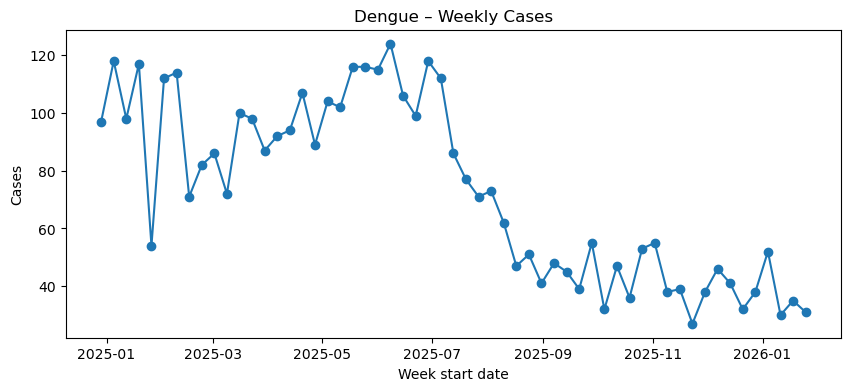

In [98]:
import matplotlib.pyplot as plt

ts = df_total[df_total["disease"] == "Dengue"].sort_values("week_start")

plt.figure(figsize=(10,4))
plt.plot(ts["week_start"], ts["cases"], marker="o")
plt.title("Dengue – Weekly Cases")
plt.xlabel("Week start date")
plt.ylabel("Cases")
plt.show()
